## Modelos lineales para clasificación

Podemos usar la función de la regresión lineal para intentar ajustar un modelo de clasificación:

<img src=https://amueller.github.io/ml-workshop-2-of-4/slides/images/linear_boundary_vector.png width=400>

$$\hat{y}_i = f(x_i) = \text{sign}\big(w_0 + w_1x_1 + w_2x_2 + \dots + w_dx_d\big)$$

Función de pérdida:

$$L(y_i, \hat{y_i}) = \sum_{i=1}^{n} \left\{ \begin{array}{cc} 0 & \text{si } y_i = \hat{y}_i \\ 1 & \text{si } y_i \neq \hat{y}_i \end{array} \right.$$

**Problema**: no podemos calcular derivadas, por tanto no podemos calcular los $w$ que minimizan la pérdida media

### Regresión logística

El equivalente a la regresión lineal para problemas de clasificación es la regresión logística. Reemplaza la pérdida zero-uno por una "aproximación", la pérdida logística:

$$L(y_i, \hat{y_i}) = \log(\exp(-y_i\hat{y}_i) + 1)$$

Comparación con la pérdida 0-1:

<img src=../../img/loss_comparison.png width=500>

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

blood = fetch_openml('blood-transfusion-service-center')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(blood.data, blood.target, random_state=0)

In [4]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='none')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7165775401069518

In [5]:
import pandas as pd
prob = pd.DataFrame(lr.predict_proba(X_test), columns=['prob_clase_1', 'prob_clase_2'])
prob['clase'] = lr.predict(X_test)

In [6]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

prob.head(5).style.apply(highlight_max, subset=['prob_clase_1', 'prob_clase_2'], axis=1)

,prob_clase_1,prob_clase_2,clase
0,0.751464,0.248536,1
1,0.569721,0.430279,1
2,0.568277,0.431723,1
3,0.576968,0.423032,1
4,0.133358,0.866642,2


### Regresión logística regularizada

Al igual que añadimos un término de regularización a la regresión lineal, podemos añadirlo también a la regresión logística. En este caso no hay clases específicas, sino que hay que ajustar los valores del parámetro `penalty`:

   * `penalty=l1`, regularización $l_1$ (como Lasso)
   * `penalty=l2`, regularización $l_2$ (como Ridge)
   * `penalty=elasticnet`, regularización $l_1$ + regularización $l_2$ (como ElasticNet)
   
**Ojo**: por defecto la clase `LogisticRegression` incluye regularización $l_2$ (`penalty=l2`)

Podemos usar la clase `LogisticRegressionCV` para buscar automáticamente el valor óptimo de los parámetros `C` y `l1_ratio`

In [7]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(breast.data, breast.target, random_state=42)

In [8]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.965034965034965

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [10]:
from sklearn.linear_model import LogisticRegressionCV

lrcv = LogisticRegressionCV(Cs=10, solver='liblinear')
lrcv.fit(X_train_std, y_train)
lrcv.score(X_test_std, y_test)

0.986013986013986

In [11]:
lrcv.C_

array([0.04641589])

### Métricas de clasificación

La mayoría de métricas se pueden derivar de la [matriz de confusión](https://en.wikipedia.org/wiki/Confusion_matrix):

<img src=../../img/confusion_matrix.png width=250>

 * Accuracy: $\frac{\text{TP} + \text{TN}}{\text{P} + \text{N}}$
 
 
 * Sensitivity, recall, TPR: $\frac{\text{TP}}{\text{TP} + \text{FN}}$


 * Specificity, TNR: $\frac{\text{TN}}{\text{TN} + \text{FP}}$


 * Precision, PPV: $\frac{\text{TP}}{\text{TP} + \text{FP}}$


 * F1 score: $2\times \frac{\text{PPV} \times \text{TPR}}{\text{PPV} + \text{TPR}}$

Las etiquetas positivo y negativo son arbitrarias, aunque se suelen denominar ejemplos positivos a la clase minoritaria.

 * Documentación API: [metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics)
 
 * Guía de usuario: [Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

 * [Visualizations with Display Objects](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py)

In [12]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

ypred = lr.predict(X_test)
cm = confusion_matrix(y_test, ypred)

pd.DataFrame(cm, index=['real_0', 'real_1'], columns=['pred_0', 'pred_1'])

,pred_0,pred_1
real_0,51,3
real_1,2,87


/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


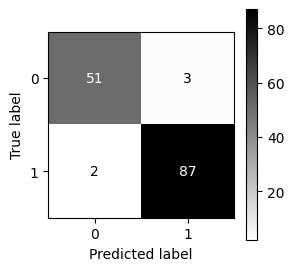

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(lr, X_test, y_test, cmap='gray_r', ax=ax);

In [14]:
tn, fp, fn, tp = cm.ravel()
print(tn)
print(tp)
print(fp)
print(fn)

51
87
3
2


### Problemas de clasificación no balanceados

La tasa de acierto no es útil para problemas donde una clase está mucho menos representada que otra:

In [15]:
import pandas as pd
df = pd.read_csv('../../data/balance-scale.data',  names=['balance', 'var1', 'var2', 'var3', 'var4'])

df['balance'] = [1 if b=='B' else 0 for b in df['balance']]
df['balance'].value_counts()

0    576
1     49
Name: balance, dtype: int64

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix

X = df.drop(columns='balance').values
y = df['balance'].values

model = LogisticRegression(solver='liblinear')
model.fit(X, y)
ypred = model.predict(X)
print(model.score(X, y) * 100)

92.16


/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


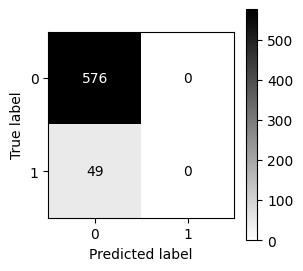

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(model, X, y, cmap='gray_r', ax=ax);

In [18]:
print(classification_report(y, ypred, zero_division=0))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       576
           1       0.00      0.00      0.00        49

    accuracy                           0.92       625
   macro avg       0.46      0.50      0.48       625
weighted avg       0.85      0.92      0.88       625



Tasa de acierto balanceada: 0.5 por predicciones aleatorias, igual a la tasa de acierto para datos balanceados:

$$\text{tasa_acierto_balanceada} = \frac{1}{2}\left(\frac{\text{TP}}{\text{TP} + \text{FN}} + \frac{\text{TN}}{\text{TN} + \text{FP}}\right)$$

In [19]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y, ypred)

0.5

#### Ejemplo breast-cancer

In [20]:
import pandas as pd

data = pd.read_csv("../../data/breast-cancer.data", header=None, na_values='?')

In [21]:
data_clean = data.dropna()

X = pd.get_dummies(data_clean.drop(columns=9))
y = (data_clean.iloc[:, 9] == 'yes').astype('int')

In [22]:
pd.Series(y).value_counts()

0    215
1     62
Name: 9, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

ypred = model.predict(X_test)
print(classification_report(y_test, ypred, zero_division=0))
print(model.score(X_test, y_test))
balanced_accuracy_score(y_test, ypred)

              precision    recall  f1-score   support

           0       0.80      0.94      0.86        54
           1       0.50      0.19      0.27        16

    accuracy                           0.77        70
   macro avg       0.65      0.57      0.57        70
weighted avg       0.73      0.77      0.73        70

0.7714285714285715


/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.5659722222222222

#### Cambiar umbral de probabilidad

In [24]:
ypred = model.predict_proba(X_test)[:, 1] > 0.2
print(classification_report(y_test, ypred, zero_division=0))
print(balanced_accuracy_score(y_test, ypred))

              precision    recall  f1-score   support

           0       0.83      0.56      0.67        54
           1       0.29      0.62      0.40        16

    accuracy                           0.57        70
   macro avg       0.56      0.59      0.53        70
weighted avg       0.71      0.57      0.61        70

0.5902777777777778


/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


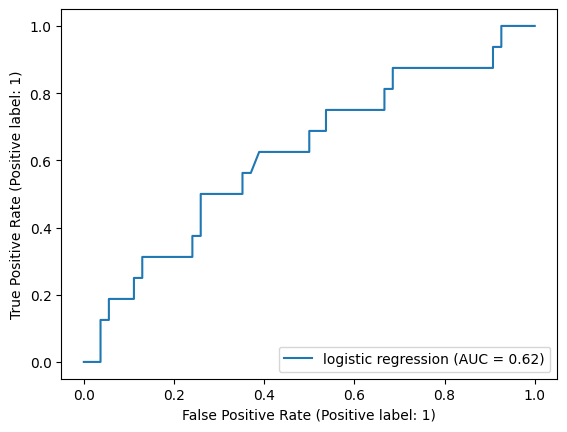

In [25]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

plot_roc_curve(model, X_test, y_test, name='logistic regression');

#### Pesos para cada clase

* Se pueden asignar pesos distintos a la función de pérdida para que tenga más en cuenta las muestras de la clase minoritaria. 

* Funciona para la mayoría de modelos de scikit-learn (atributo `class_weight`)

In [26]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

array([0.64285714, 2.25      ])

/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


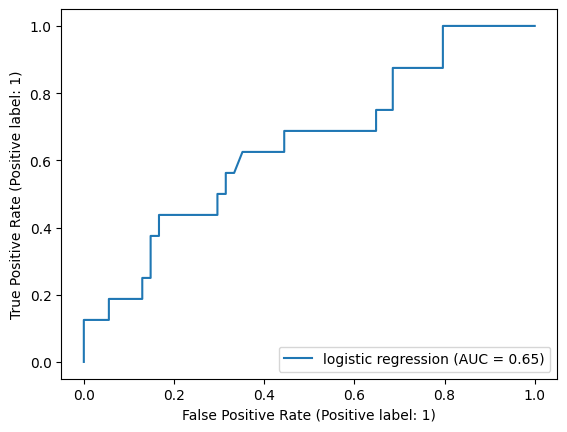

In [27]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)
plot_roc_curve(model, X_test, y_test, name='logistic regression');

#### Buscar parámetros usando otras métricas 

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.logspace(-4, 4, 10),
              'penalty': ['l1', 'l2']}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', solver='liblinear'), 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring=['roc_auc', 'balanced_accuracy'], 
                    refit='roc_auc')

grid.fit(X_train, y_train)
grid.best_params_

/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  war

/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  war

/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  war

/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  war

/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  war

{'C': 0.046415888336127774, 'penalty': 'l2'}

In [30]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,...,split3_test_balanced_accuracy,split4_test_balanced_accuracy,split5_test_balanced_accuracy,split6_test_balanced_accuracy,split7_test_balanced_accuracy,split8_test_balanced_accuracy,split9_test_balanced_accuracy,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy
0,0.001275,0.000155,0.002287,0.000452,0.0001,l1,"{'C': 0.0001, 'penalty': 'l1'}",0.500000,0.5000,0.5000,...,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.500000,0.000000,17
1,0.001368,0.000309,0.002427,0.000604,0.0001,l2,"{'C': 0.0001, 'penalty': 'l2'}",0.647059,0.9000,0.8625,...,0.71250,0.73750,0.58125,0.58125,0.62500,0.65625,0.81250,0.687647,0.097181,3
2,0.001193,0.000066,0.002133,0.000414,0.000774,l1,"{'C': 0.000774263682681127, 'penalty': 'l1'}",0.500000,0.5000,0.5000,...,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.500000,0.000000,17
3,0.001239,0.000150,0.002049,0.000240,0.000774,l2,"{'C': 0.000774263682681127, 'penalty': 'l2'}",0.647059,0.9125,0.8625,...,0.71250,0.73750,0.58125,0.58125,0.68750,0.65625,0.81250,0.686838,0.082701,4
4,0.001135,0.000025,0.001962,0.000081,0.005995,l1,"{'C': 0.005994842503189409, 'penalty': 'l1'}",0.500000,0.5000,0.5000,...,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.500000,0.000000,17
5,0.001183,0.000050,0.002094,0.000377,0.005995,l2,"{'C': 0.005994842503189409, 'penalty': 'l2'}",0.647059,0.9250,0.8625,...,0.67500,0.76875,0.70625,0.64375,0.65625,0.65625,0.81250,0.707537,0.085616,1
6,0.001139,0.000024,0.001961,0.000039,0.046416,l1,"{'C': 0.046415888336127774, 'penalty': 'l1'}",0.500000,0.5000,0.5000,...,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.500000,0.000000,17
7,0.001234,0.000124,0.001982,0.000052,0.046416,l2,"{'C': 0.046415888336127774, 'penalty': 'l2'}",0.647059,0.9250,0.8625,...,0.67500,0.76875,0.70625,0.64375,0.65625,0.53125,0.84375,0.707169,0.099353,2
8,0.001474,0.000223,0.002325,0.000556,0.359381,l1,"{'C': 0.3593813663804626, 'penalty': 'l1'}",0.573529,0.9125,0.8375,...,0.70625,0.66875,0.67500,0.51250,0.59375,0.53125,0.71875,0.659228,0.100407,5
9,0.001438,0.000336,0.002150,0.000259,0.359381,l2,"{'C': 0.3593813663804626, 'penalty': 'l2'}",0.617647,0.9250,0.8375,...,0.57500,0.63750,0.67500,0.44375,0.68750,0.46875,0.87500,0.657794,0.136461,6


In [28]:
grid.score(X_test, y_test)

0.6753472222222222

Lista completa de métricas: [The scoring parameter: defining model evaluation rules](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

Existen también otras estrategias implementadas en la librería [imbalanced-learn](https://imbalanced-learn.org/stable/)

Más información: [Andreas C. Müller. Imbalanced Data](https://amueller.github.io/ml-workshop-4-of-4/slides/01-imbalanced-data.html#1)

In [29]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline

In [30]:
data = pd.read_csv('../../data/adult.csv', na_values = '?', index_col=0)

data = data.dropna()

X = data.drop(columns='income')
y = data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [31]:
preprocessing = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_exclude='number')),
    remainder=StandardScaler()
)

pipe = make_pipeline(preprocessing, RandomForestClassifier())

In [32]:
param_grid = {'randomforestclassifier__n_estimators': [100, 250, 500],  
              'randomforestclassifier__max_depth': [None, 2, 4, 8],
              'randomforestclassifier__min_samples_split': [2, 3, 4],
              'randomforestclassifier__max_leaf_nodes': [5, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [33]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7efe1e9844d0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [None, 2, 4, 8],
                         'randomforestclassifier__max_leaf_nodes': [5, 10],
                         'randomforestclassifier__min_samples_split': [2, 3, 4],
                         'randomforestclassifier__n_estimators': [100, 250,
                      

### Ejercicios

#### Ejercicio 1

Carga el conjunto de datos `adult.csv` usando pandas:

   * Transforma las variables categóricas usando codificación *one-hot*
   
   * Escala las variables para que tengan media 0 y desviación 1
   
   * Ajusta un modelo de regresión logística y visualiza los coeficientes
   
   * Busca el valor óptimo del parámetro $C$ usando validación cruzada
   
   * Prueba ahora con regularización `elasticnet` y busca el valor óptimo del parámetro `l1_ratio`

#### Ejercicio 2

Carga el conjunto de datos `bank-campaign.csv`:

  * Ver el tipo de las variables y transformar a numérica si es necesario
  
  * Ver la proporción de ejemplos de cada clase (variable `target`)
  
  * Dividir en entrenamiento-test y ajustat un clasificador.
  
  * Mostrar la matriz de confusión. ¿Ha aprendido algo el clasificador? ¿Como podemos solucionarlo?
  
  * Mostrar la curva ROC

#### Ejercicio 3

Carga el conjunto de datos `titanic.csv` usando pandas:

   * Eliminar las variables `Cabin` y `Name`

   * Completar los valores que faltan en la edad con la media

   * Convertir las variables no numéricas en numéricas con `.get_dummies()`
   
   * Particionar el conjunto en train/test
   
   * Normalizar las variables para que tengan media 0 y varianza 1
   
   * Ajustar un modelo de Regresión Logística. Prueba con distintas regularizaciones
   
   * Realizar un gráfico de los coeficientes
   
   * Calcular la matriz de confusión, f1-score, precision y recall en el conjunto de test. ¿Como se interpretan estos resultados? ¿Observas algún problema?
   
   * Buscar los parámetros óptimos del modelo usando validación cruzada